In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from transformers import GPT2Tokenizer, GPT2LMHeadModel

from utils.retrieval import get_activations, extract_weights
from utils.storage import save_overlaps, save_svals

In [13]:
gpt2_version = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(gpt2_version)
model = GPT2LMHeadModel.from_pretrained(gpt2_version, output_hidden_states=True, return_dict_in_generate=True)

In [14]:
# constants of the model
TOTAL_VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIMENTIONS = 768
MAXIMUM_INPUT_LENGTH = 1024
N_BLOCKS = 12

In [15]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [16]:
# generating random prompts of a fixed token size
n_tokens = 100
n_prompts = 1
prompts = [torch.randint(0, TOTAL_VOCAB_SIZE, size = (1, n_tokens)) for _ in range(n_prompts)]

In [17]:
# registering the hooks and initializing the dict to store all activations
activations = get_activations(model)

In [18]:
# runnning all the prompts to obtain all activations
for prompt in prompts:
    with torch.no_grad():
        _ = model(prompt)

In [19]:
# extracting all the weights from the transformer
weights = extract_weights(model)

In [20]:
# run parameters
plotting = True
plotting_js = False

# performs the decomposition and analysis of only the layers specified
sublayer_selection = [
    # "attn.c_attn.q"
    # "attn.c_attn.k",
    # "attn.c_attn.v",
    # "attn.c_proj"
    # "mlp.c_fc"
    "mlp.c_proj"
]

# dictionary to store all svals of a layer
svals_dict = {} 

# dictionary to store all overlaps of a layer
overlaps_dict = {}

TO DO:
- analysis after added input buffer
- analysis using determined prompts
- analysis using different sized prompts

#####

BLOCK 0

#####

torch.Size([768, 768]) torch.Size([768, 768])


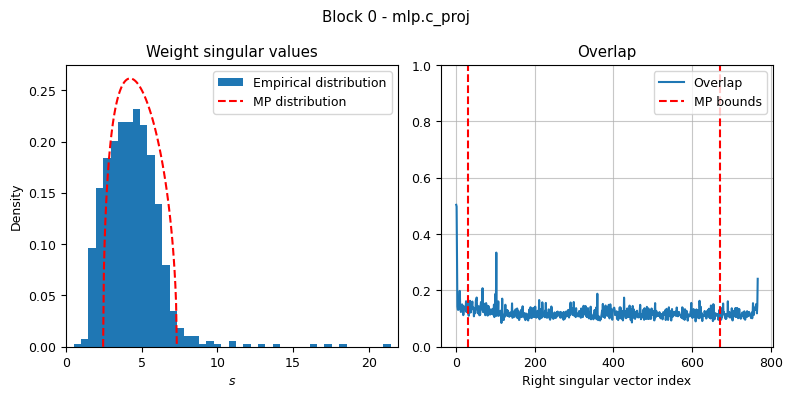

#####

BLOCK 1

#####

torch.Size([768, 768]) torch.Size([768, 768])


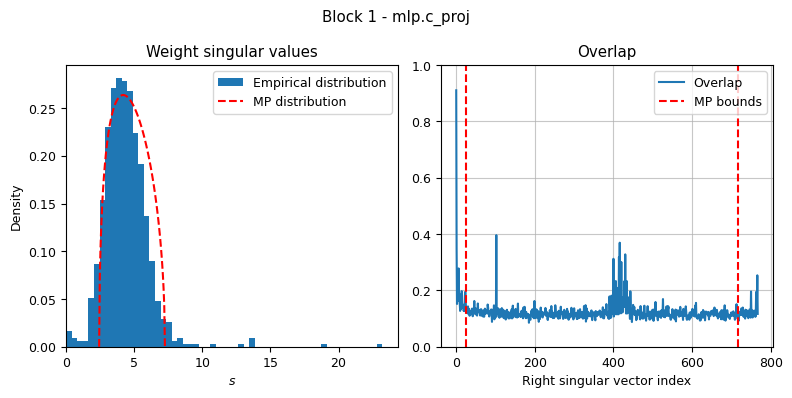

#####

BLOCK 2

#####

torch.Size([768, 768]) torch.Size([768, 768])


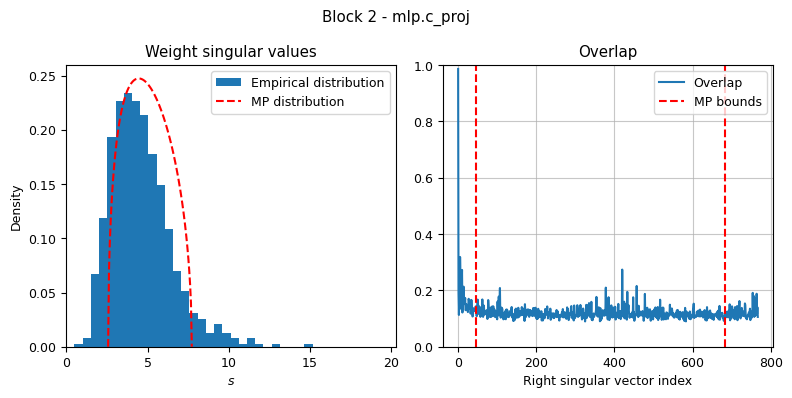

#####

BLOCK 3

#####

torch.Size([768, 768]) torch.Size([768, 768])


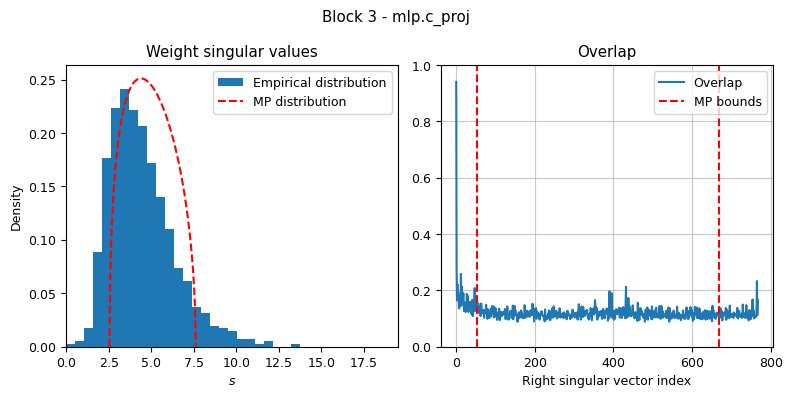

#####

BLOCK 4

#####

torch.Size([768, 768]) torch.Size([768, 768])


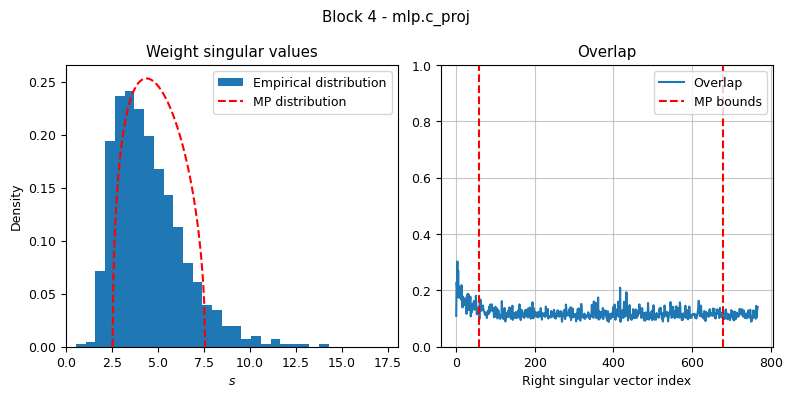

#####

BLOCK 5

#####

torch.Size([768, 768]) torch.Size([768, 768])


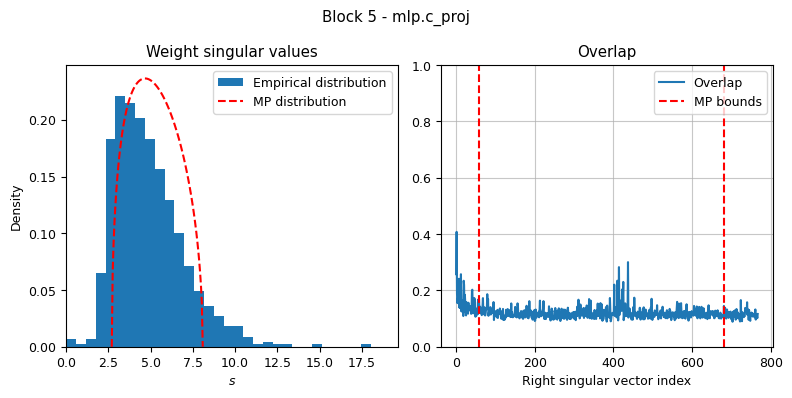

#####

BLOCK 6

#####

torch.Size([768, 768]) torch.Size([768, 768])


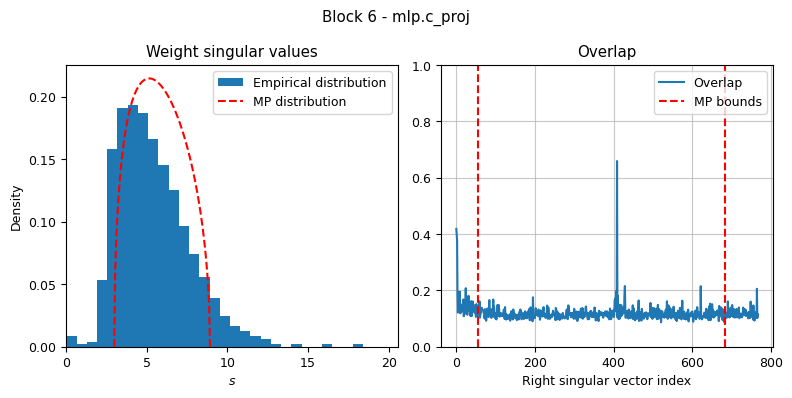

#####

BLOCK 7

#####

torch.Size([768, 768]) torch.Size([768, 768])


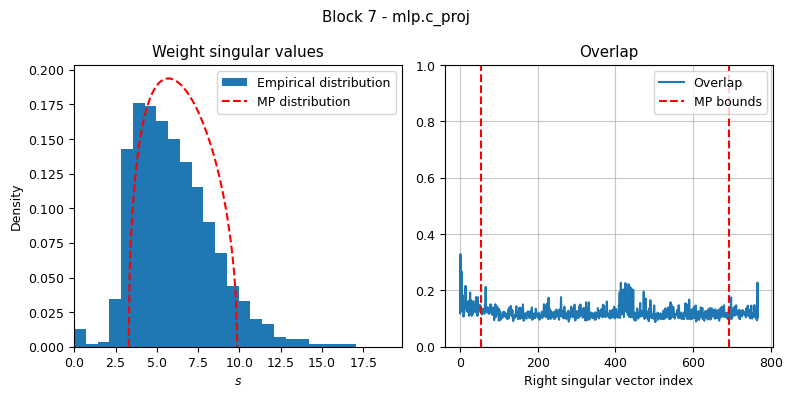

#####

BLOCK 8

#####

torch.Size([768, 768]) torch.Size([768, 768])


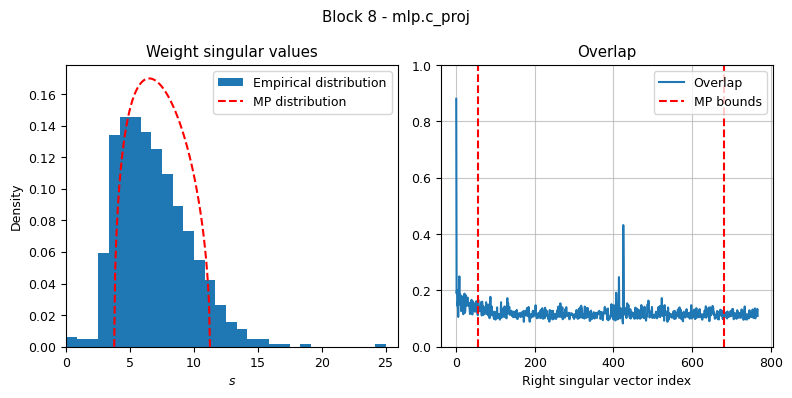

#####

BLOCK 9

#####

torch.Size([768, 768]) torch.Size([768, 768])


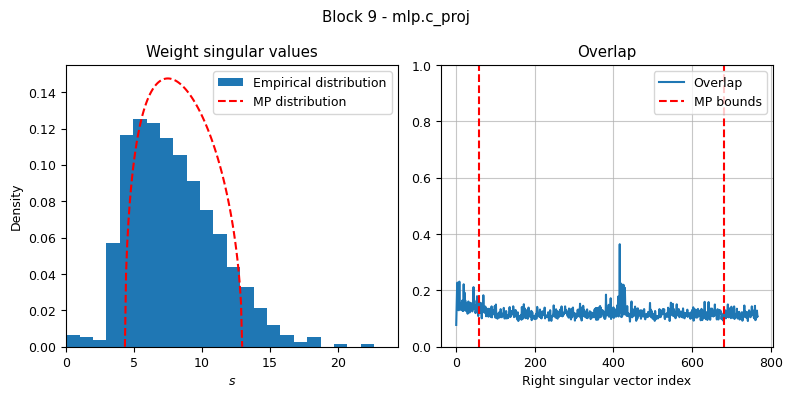

#####

BLOCK 10

#####

torch.Size([768, 768]) torch.Size([768, 768])


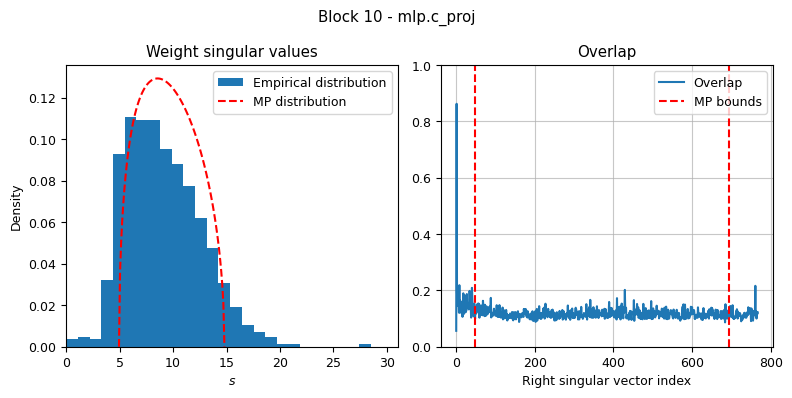

#####

BLOCK 11

#####

torch.Size([768, 768]) torch.Size([768, 768])


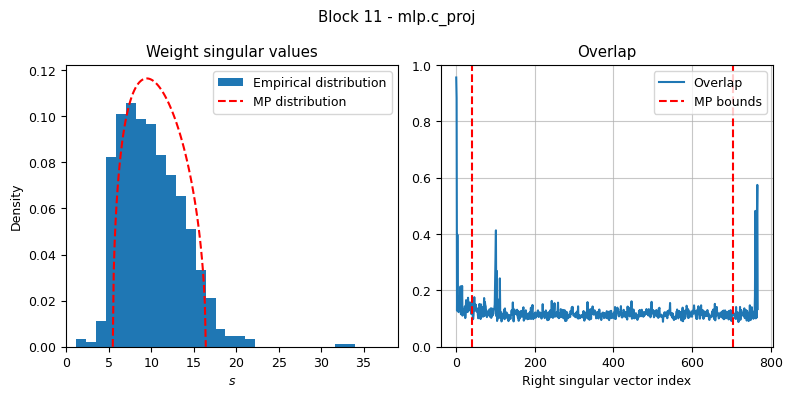

In [21]:
for block_idx in range(N_BLOCKS):

    print("#####\n")
    print(f"BLOCK {block_idx}\n")
    print("#####\n")

    def slice_acts(key):
        """
        Function that returns all entries in `activations[key]` that correspond to the current `block_idx`
        """
        acts = activations[key]
        current_block_acts = []
        for i in range(n_prompts):
            selected_act = acts[i * N_BLOCKS + block_idx]
            n, d = selected_act.shape
            current_block_acts.append(selected_act.reshape(1,n,d))
        return torch.cat(current_block_acts, dim=0)
    
    # dict containing all weights and activations for each sublayer of the current `block_idx`
    sublayers = {
        sublayer: {"W": weights[f"h.{block_idx}.{sublayer}.weight"],"X": slice_acts(sublayer)} for sublayer in activations.keys()
    }

    for name, info in sublayers.items():
        if name not in sublayer_selection: continue

        W = info["W"] # weights
        X = info["X"] # buffers
        _, N, D = X.shape # the first dimention is n_prompt

        ###

        # computing the activation covariance matrix as defined in the paper
        x_mean = torch.mean(X, dim = [0,1])
        x_centered = X - x_mean
        act_cov = torch.sum(torch.matmul(torch.transpose(x_centered, 1, 2), x_centered), dim = 0) / (n_prompts * (N - 1))
        
        act_cov_eigvals, act_cov_eigvecs = torch.linalg.eigh(act_cov)

        # inverting the ordering (now descending)
        act_cov_eigvals = act_cov_eigvals.flip(0)
        act_cov_eigvecs = act_cov_eigvecs.flip(1)
        
        ###

        # analyse as projection operator

        # computing the singular values of the centered weight matrix
        w_mean = torch.mean(W, dim = 0)
        w_centered = W - w_mean

        _, w_svals, w_Vt = torch.linalg.svd(w_centered)

        max_rank = np.min(W.shape)

        # removing all eigenvalues we are sure to be 0
        w_svals = w_svals[:max_rank]
        w_Vt = w_Vt[:max_rank,:]

        svals_dict[f"{name}.{block_idx}"] = w_svals.detach().numpy()

        # and the corresponding eigenvectors in the act_cov
        act_cov_eigvals = act_cov_eigvals[:max_rank]
        act_cov_eigvecs = act_cov_eigvecs[:,:max_rank]

        # debug
        print(act_cov_eigvecs.shape, w_Vt.shape)

        ### 

        # computing the overlap between w and act_cov sigular vectors
        # this could signify how much information is transfered from the weights to the buffer
        overlap = torch.max(torch.matmul(w_Vt, act_cov_eigvecs), dim = 0)[0]

        ###

        # marchenko-pastur parameters

        q = W.shape[1] / W.shape[0]

        sigma = torch.std(w_centered)

        s_lower = sigma * np.fabs(np.sqrt(W.shape[0]) - np.sqrt(W.shape[1]))
        s_upper = sigma * np.fabs(np.sqrt(W.shape[0]) + np.sqrt(W.shape[1]))


        def mp_distribution(x):
            """
            Marchenko-Pastur distribution
            """
            def _dist(x):
                return torch.sqrt((s_upper**2 - x**2) * (x**2 - s_lower**2)) / (torch.pi * sigma**2 * q * x)
            
            return torch.where(
                torch.logical_and(x > s_lower, x < s_upper),
                _dist(x),
                0
            )

        x_mp = torch.linspace(s_lower, s_upper, 100) 
        # the first element is removed because if 0 it leads to division error
        if (x_mp[0] < 1e-6):
            x_mp = x_mp[1:]
        mp = mp_distribution(x_mp)
        mp = mp / torch.trapezoid(mp, x_mp) # renormalizing the distribution

        # finding the bordering eigvalues w.r.t. the mp distribution

        idx_lower = np.argmin(torch.abs(w_svals - s_lower))
        idx_upper = np.argmin(torch.abs(w_svals - s_upper))

        # plotting 
        if (plotting):
            counts, bins = np.histogram(w_svals.detach().numpy(), bins = "fd", density=True, range = [0, max(w_svals.detach().numpy())])

            plt.rcParams.update({'font.size': 9})
            fig, axs = plt.subplots(ncols=2, figsize = (8, 4))

            # w svals distribution plot
            axs[0].hist(bins[:-1], bins, weights = counts, label = "Empirical distribution")
            axs[0].plot(x_mp, mp, linestyle = "--", color = "r", label = "MP distribution")
            axs[0].set_xlim(0, torch.quantile(w_svals, 0.999))
            axs[0].set_title("Weight singular values")
            axs[0].set_xlabel(r"$s$")
            axs[0].set_ylabel("Density")
            axs[0].legend()

            # overlap plot
            axs[1].plot(np.arange(overlap.shape[0]), overlap, label = "Overlap")
            axs[1].vlines(x = [idx_lower, idx_upper], ymin = 0, ymax = 1, color = "r", linestyle = "--", label = "MP bounds")
            axs[1].grid(alpha = 0.7)
            axs[1].set_ylim(0,1)
            axs[1].set_title("Overlap")
            axs[1].set_xlabel("Right singular vector index")
            axs[1].legend()

            fig.suptitle(f"Block {block_idx} - {name}")
            fig.tight_layout()
            plt.show()
            fig.clear()
            plt.close(fig)

In [22]:
save_svals(svals_dict, sublayer_selection[0])